## Classification of Income Being Above or Below/Equal to $50,000 in Adult Census Data

By: Sunsar, Sarah, Emily, Calvin (DSCI 100 003 - Group 23)

Data is from: https://www.kaggle.com/datasets/uciml/adult-census-income

The dataset used for this analysis is derived from the 1994 Census Bureau database. 

The dataset contains a diverse range of numerical and categorical attributes, such as age, hours worked per week,  sex, and more. In this project, we will filter and simplify some categories from this dataset to predict whether an individual"s annual salary falls above or below/equal to $50,000.

The question this project will seek to answer is: 

**How do different aspects of a person predict whether annual income will be above or below/equal to $50K annually?**

# Reading in Data

In [1]:
library(tidyverse)
library(tidymodels)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.3     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.3     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
-- Attaching packages -------------------------------------- tidymodels 1.1.1 --

v broom        1.0.5     v rsample      1.2.0
v dials        1.2.0     v tune         1.1.2
v infer        1.0.5     v workflows    1.1.3
v modeldata    1.2.0     v workflowsets 1.0.1
v parsnip      1.1.1     v yardstick    1.2.0
v recipes      1.0.8     

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x scales::discard() masks purrr::discard()
x dplyr::filt

In [2]:
df = read_csv("https://raw.githubusercontent.com/calvingdu/dsci100-003-23/master/data/adult_census.csv")

# Splitting the data
df_split <- initial_split(df, prop = 0.8, strata = income)
df_train <- training(df_split)
df_test <- testing(df_split)

paste0("Training set row count: ", nrow(df_train))
paste0("Testing set row count: ", nrow(df_test))

Rows: 32561 Columns: 15
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (9): workclass, education, marital.status, occupation, relationship, rac...
dbl (6): age, fnlwgt, education.num, capital.gain, capital.loss, hours.per.week

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Training set row count: 26048"

[1] "Testing set row count: 6513"

In [3]:
head(df_train, 3)

age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K


# Tidying/Cleaning The Data & Selecting Columns
We can begin by tidying up the data. Something we noticed immediately that there are a lot of categorical columns. To tackle this, we plan to make buckets of categories and then turn them into dummy variables. For example, we can turn __sex__ into a dummy variable where 0 = male and 1 = female, make dummy variables by bucketting different things such as paid/unpaid in __workclass__, or making a dummy variable for every unique value. 

These are the columns we plan to use and how we plan to tackle them to make them usable in data: 
- **Age**: No changes (either than scaling/imputation)
- **Workclass**: Make a dummy variable for paid/unpaid
- **Education**: Simplified to a dummy variable of if College Graduate or Not
- **Occupation**: Make a dummy variable for all the occupations
- **Relationship**: Simplified a dummy variable of Married or Not
- **Sex**: Transformed into a Dummy Variable
- **Capital Gain**: No changes (either than scaling/imputation)
- **Capital Loss**: No changes (either than scaling/imputation)
- **Hours Per Week**: No changes (either than scaling/imputation)
- **Native Country**: Evaluated what country has the most people with income > 50k (United States by a large margin) and then make a dummy variable for being in this country or not 

**Dropped Columns & Reasoning**: 
- fnlwgt: Unclear how this relates
- education.num: Already have education
- race: Don"t believe this is significant to the study so removing to avoid overfitting 
- marital.status: We think it"s similar to relationship so we remove to avoid overfitting 


This is also some tidying to do. We can initially see that there are some missing values in __workclass__ and __occupation__ represented as ?. Since we believe these are extremely important roles to guess income category, we remove any rows that don't have data for this. 

In [4]:
filtered_df <- df_train |>
  select(age, workclass, education, occupation, relationship, sex,
         capital.gain, capital.loss, hours.per.week, native.country, income) |>
  filter(workclass != "?" & occupation != "?")

Then, we can begin by making dummy variables in the data using the above choices

### Binary Preprocessing

In [5]:
# Making a function to be used later
preprocess_binary <- function(df){
    transformed_df <- df |>
        mutate(is_married = ifelse((relationship == "Husband" | relationship == "Wife" |relationship == "Wife"),1,0)) |>
        mutate(sex_dummy = ifelse(sex == "Female", 1, 0)) |>
        mutate(being_paid = ifelse(workclass != "Self-emp-not-inc" & workclass != "Without-pay" & workclass != "Never-worked", 1, 0)) |>
        mutate(is_american = ifelse(native.country == "United-States", 1, 0))
    return(transformed_df)
}

binary_df <- preprocess_binary(filtered_df)

### Dummy Variables for Every Occupation

In [6]:
unique_occupations <- as.list(unique(binary_df$occupation))

# Making a function to use later
preprocess_occupation <- function(df, occupations){
    for (occ in occupations) {
        col_name <- gsub("[^a-zA-Z0-9 ]", ".", tolower(occ))
        df[[col_name]] <- as.integer(df$occupation == occ)
    }
    return(df)
}

occupations_df <- preprocess_occupation(binary_df, unique_occupations)

### Removing Original Variables

In [7]:
tidy_df <- occupations_df |>
    select(-c(occupation, workclass, education, occupation, relationship, sex, native.country))

head(tidy_df)

age,capital.gain,capital.loss,hours.per.week,income,is_married,sex_dummy,being_paid,is_american,exec.managerial,...,adm.clerical,sales,transport.moving,craft.repair,farming.fishing,tech.support,handlers.cleaners,protective.serv,priv.house.serv,armed.forces
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
82,0,4356,18,<=50K,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
54,0,3900,40,<=50K,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
41,0,3900,40,<=50K,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
34,0,3770,45,<=50K,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
38,0,3770,40,<=50K,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
61,0,2754,25,<=50K,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0


Below is an function that does all of our pre-processing. It can be verified by checking if the changes we made above are the same as the changes made by the function

In [8]:
process_df <- function(df){
    filtered_df <- df |>
    select(age, workclass, education, occupation, relationship, sex,
            capital.gain, capital.loss, hours.per.week, native.country, income) |>
    filter(workclass != "?" & occupation != "?")

    binary_df <- preprocess_binary(filtered_df)

    unique_occupations <- as.list(unique(binary_df$occupation))
    occupations_df <- preprocess_occupation(binary_df, unique_occupations) 
    new_cols_df <- select(occupations_df, -c(occupation, workclass, education, occupation, relationship, sex, native.country))

    return(new_cols_df)
}

processed_df_train <- process_df(df_train)
print(all.equal(processed_df_train, tidy_df) & all.equal(colnames(processed_df_train), colnames(tidy_df)))

[1] TRUE


# Preliminary Exploratory Data Analysis



## Summary Table

In [9]:
summary_table <- tidy_df |>
group_by(income) |>
summarize(across(everything(), ~ round(mean(., na.rm = TRUE), 2), .names = "mean_{.col}")) 

summary_table

income,mean_age,mean_capital.gain,mean_capital.loss,mean_hours.per.week,mean_is_married,mean_sex_dummy,mean_being_paid,mean_is_american,mean_exec.managerial,...,mean_adm.clerical,mean_sales,mean_transport.moving,mean_craft.repair,mean_farming.fishing,mean_tech.support,mean_handlers.cleaners,mean_protective.serv,mean_priv.house.serv,mean_armed.forces
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<=50K,36.59,145.31,53.78,39.35,0.33,0.38,0.92,0.89,0.09,...,0.14,0.12,0.06,0.14,0.04,0.03,0.05,0.02,0.01,0
>50K,43.95,4068.02,200.87,45.75,0.85,0.15,0.91,0.91,0.25,...,0.07,0.13,0.04,0.12,0.01,0.04,0.01,0.03,0.00,0


This table shows the mean value for every column in each category split by the income category

## EDA Visualization

An example of a visualization we can do is look at how variable affect the income category. For example, we believe age has high predictive power and we want to see how the proportion of people with income >50k changes with age. 

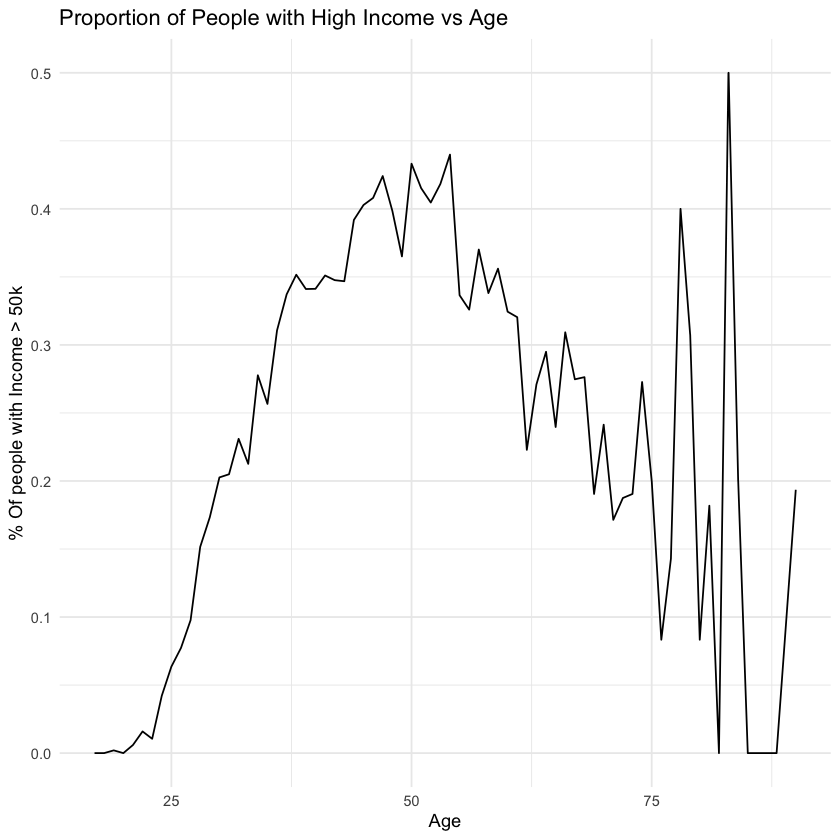

In [10]:
age_plot <- tidy_df %>%
  group_by(age) %>%
  summarise(proportion = sum(income == ">50K") / n()) |>
    ggplot(aes(x = age, y = proportion)) +
    geom_line() +
    labs(x = "Age", y = "% Of people with Income > 50k") +
    ggtitle("Proportion of People with High Income vs Age") + 
    theme_minimal()
  
  age_plot

# Methods

For our data analysis, we will perform classification using the variables seen above. For our classification, we will use the knn algorithm (or using logistic regression) which will determine the income of the person based on the categories. We will follow the steps outlined in the class by first creating a recipe for the model, training our data using the k nearest neighbors function by choosing and optimizing the most appropriate K, and then using the fit function to fit the specification on our dataset. All these steps will be combined using the workflow. After, we will apply the dataset to predict function to get the final result.

The visualizations will be done by plotting a bar graph to show which factors will have the greatest impact on the annual income of a person. This can represent how important some variables are in terms of coefficients or predictive power.

We can also use the above graph as an example, and repeat this for different variables/groupings of variables


# Expected outcomes and significance

We expect to identify certain variables having greater or lesser importance in predicting annual income. For example, we believe that age is a major contributer to identifying income. 

The impact of comparing the effects of different categories on an individual's annual income is that viewers will be able to discern which factors hold more or less significance. 

This analysis may potentially lead to further questions regarding why specific socio-economic variables have a more prominent impact on determining annual salary. 
